# Notebook configuration

In [134]:
run_number    = 4314
data_filename = "$ALPHASDIR/{0}/dst_{0}.root.h5".format(run_number)
text_filename = "$ICARODIR/icaro/Alphas/Lifetimes.txt"
run_comment   = ""

# Alpha lifetime

In [135]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import numpy as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.reco. dst_functions as dstf

from icaro.core.kdst_functions import event_rate
from icaro.core.kdst_functions import profile_and_fit
from icaro.core.kdst_functions import time_from_timestamp
from icaro.core.kdst_functions import to_deltatime
from icaro.core.kdst_functions import lifetime_vs_t
from icaro.core.kdst_functions import save_lifetime

2017-06-13 12:16:34


In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [137]:
full       = dstf.load_dst(os.path.expandvars(data_filename), "DST", "Events")
t_begin    = np.min(full.time)
t_end      = np.max(full.time)
run_dt     = t_end - t_begin
full.time -= t_begin
fid        = full[full.R < 100] # michel sorel cuts
cath       = full[full.Z > 500]
bulk       = full[full.Z < 500]

print("# alphas              :", len(full))
print("# alphas at R < 100 mm:", len(fid ))
print("# alphas at Z > 500 µs:", len(cath))
print("# alphas at Z < 500 µs:", len(bulk))

full.head()

# alphas              : 22966
# alphas at R < 100 mm: 5904
# alphas at Z > 500 µs: 3130
# alphas at Z < 500 µs: 19836


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,0.000,0,1,300.0,329.752441,1874.785429,458000.0,10.002313,12348.423828,...,655012.5,20,197.0125,197.0125,-106.654930,24.587282,109.452312,2.915020,9.041192,9.681597
1,6,0.382,0,1,350.0,692.934082,4629.771402,106325.0,14.796250,3064.632568,...,656812.5,12,550.4875,550.4875,122.622426,60.329155,136.659674,0.457220,8.699636,8.107150
2,7,0.500,0,1,325.0,293.487640,1668.048621,413050.0,8.664375,2401.039307,...,654412.5,9,241.3625,241.3625,-186.613752,78.175855,202.326856,2.744885,6.538677,7.583156
3,8,0.628,0,1,325.0,303.589905,1729.120028,381150.0,10.587500,5894.992188,...,655337.5,19,274.1875,274.1875,106.433071,-148.164674,182.430177,-0.947865,9.201155,10.271409
4,9,0.727,0,1,325.0,293.091949,1647.914407,397500.0,11.072313,7543.224121,...,655237.5,16,257.7375,257.7375,40.213653,128.219257,134.377512,1.266881,9.312320,8.588314


# Trigger rate

Average trigger rate: 6.19 evts/s


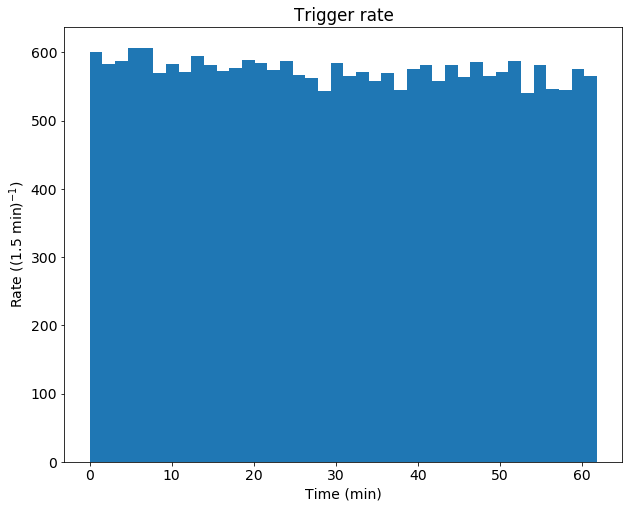

In [138]:
n, bins, _ = \
plt.hist  (full.time/60, 40)
plt.xlabel("Time (min)")
plt.ylabel("Rate (({:.1f} min)$^{{-1}}$)".format(np.diff(bins)[0]))
plt.title ("Trigger rate")

rate = event_rate(full)
print("Average trigger rate: {:.2f} evts/s".format(rate))

# Energy distributions and correlations

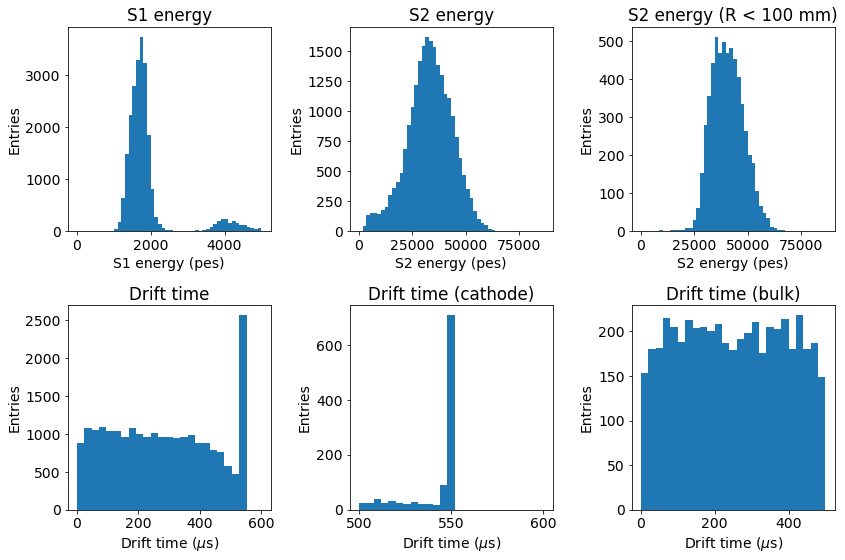

In [139]:
plt.figure (figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.hist   (full.S1e, 50, (0, np.max(full.S1e)))
plt.xlabel ("S1 energy (pes)")
plt.ylabel ("Entries")
plt.title  ('S1 energy')

plt.subplot(2, 3, 2)
plt.hist   (full.S2e, 50, (0, np.max(full.S2e) * 1.2))
plt.xlabel ("S2 energy (pes)")
plt.ylabel ("Entries")
plt.title  ('S2 energy')

plt.subplot(2, 3, 3)
plt.hist   (fid.S2e, 50, (0, np.max(full.S2e) * 1.2))
plt.xlabel ("S2 energy (pes)")
plt.ylabel ("Entries")
plt.title  ('S2 energy (R < 100 mm)')

plt.subplot(2, 3, 4)
plt.hist   (full.Z, 25, (0, 600))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("Entries")
plt.title  ('Drift time')

plt.subplot(2, 3, 5)
plt.hist   (fid.Z, 25, (500, 600))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("Entries")
plt.title  ('Drift time (cathode)')

plt.subplot(2, 3, 6)
plt.hist   (fid.Z, 25, (0, 500))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("Entries")
plt.title  ('Drift time (bulk)')

plt.tight_layout()

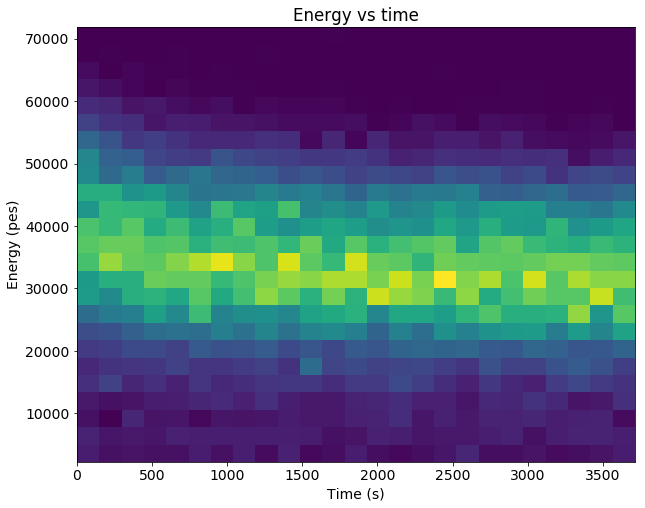

In [140]:
plt.hist2d(full.time, full.S2e, (25, 25))
plt.xlabel("Time (s)")
plt.ylabel("Energy (pes)")
plt.title ("Energy vs time");

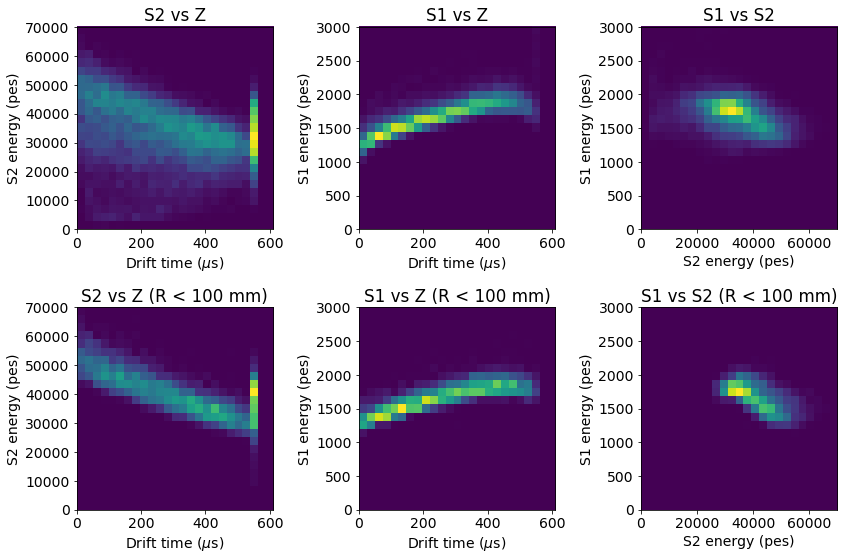

In [141]:
plt.figure(figsize=(12, 8))
zrange  = 0, 610
S2range = 0, 7e4
S1range = 0, 3e3

plt.subplot(2, 3, 1)
plt.hist2d (full.Z, full.S2e, (25, 25), range=(zrange, S2range))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("S2 energy (pes)")
plt.title  ('S2 vs Z')

plt.subplot(2, 3, 2)
plt.hist2d (full.Z, full.S1e, (25, 25), range=(zrange, S1range))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("S1 energy (pes)")
plt.title  ('S1 vs Z')

plt.subplot(2, 3, 3)
plt.hist2d (full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
plt.xlabel ("S2 energy (pes)")
plt.ylabel ("S1 energy (pes)")
plt.title  ('S1 vs S2')

plt.subplot(2, 3, 4)
plt.hist2d (fid.Z, fid.S2e, (25, 25), range=(zrange, S2range))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("S2 energy (pes)")
plt.title  ('S2 vs Z (R < 100 mm)')

plt.subplot(2, 3, 5)
plt.hist2d (fid.Z, fid.S1e, (25, 25), range=(zrange, S1range))
plt.xlabel ("Drift time ($\mu$s)")
plt.ylabel ("S1 energy (pes)")
plt.title  ('S1 vs Z (R < 100 mm)')

plt.subplot(2, 3, 6)
plt.hist2d (fid.S2e, fid.S1e, (25, 25), range=(S2range, S1range))
plt.xlabel ("S2 energy (pes)")
plt.ylabel ("S1 energy (pes)")
plt.title  ('S1 vs S2 (R < 100 mm)')

plt.tight_layout()

# Event distribution

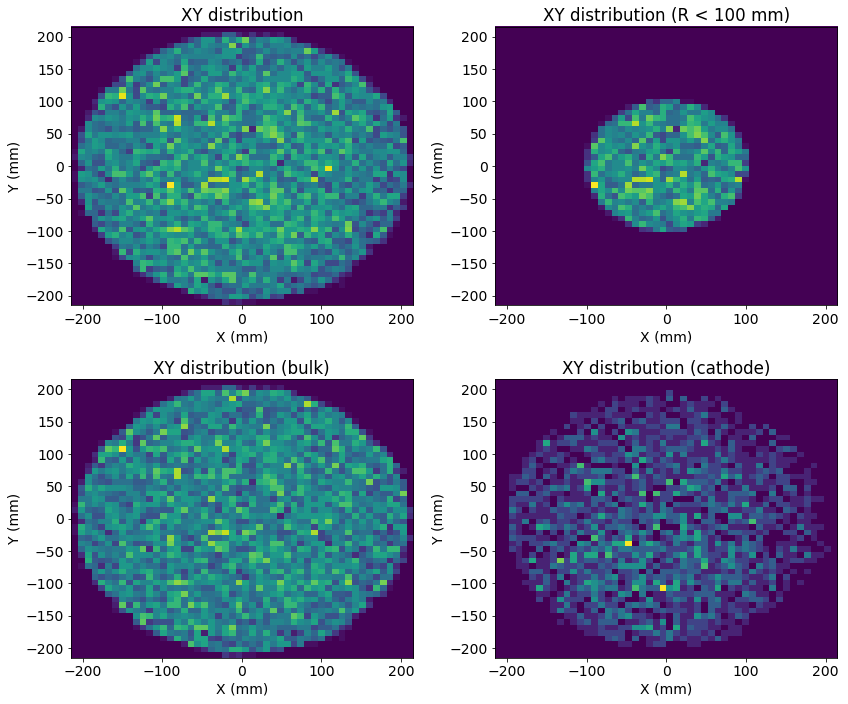

In [142]:
xrange  = -215, 215
yrange  = -215, 215
xyrange = xrange, yrange
xybins  = 50, 50

plt.figure (figsize=(12,10))
plt.subplot(2, 2, 1)
plt.hist2d (full.X, full.Y, xybins, xyrange)
plt.xlabel ("X (mm)")
plt.ylabel ("Y (mm)")
plt.title  ('XY distribution')

plt.subplot(2, 2, 2)
plt.hist2d (fid.X, fid.Y, xybins, xyrange)
plt.xlabel ("X (mm)")
plt.ylabel ("Y (mm)")
plt.title  ('XY distribution (R < 100 mm)')

plt.subplot(2, 2, 3)
plt.hist2d (bulk.X, bulk.Y, xybins, xyrange)
plt.xlabel ("X (mm)")
plt.ylabel ("Y (mm)")
plt.title  ('XY distribution (bulk)')

plt.subplot(2, 2, 4)
plt.hist2d (cath.X, cath.Y, xybins, xyrange)
plt.xlabel ("X (mm)")
plt.ylabel ("Y (mm)")
plt.title  ('XY distribution (cathode)')

plt.tight_layout()

# Lifetime

Chi2 does not get close to 1
Energy at Z=0: 53167 +- 423 pes
Lifetime     : 981.3 +- 31.2 µs 
Chi2 fit     : 3.53              


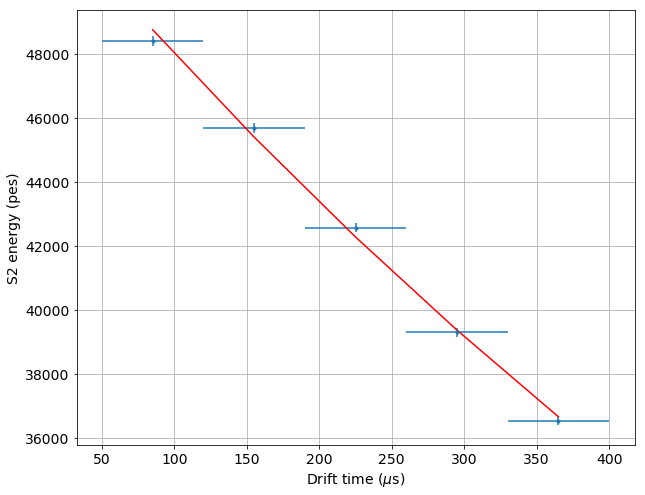

In [143]:
zrange =  50, 400
Erange = 1e4, 7e4
nbins  = 50
seed   = Erange[1], zrange[1]/np.log(Erange[0]/Erange[1])

F, x, y, sy = profile_and_fit(fid.Z, fid.S2e, 
                              xrange = zrange, 
                              yrange = Erange, 
                              nbins  = nbins, 
                              fitpar = seed,
                              label  = ("Drift time ($\mu$s)", "S2 energy (pes)"))

print("Energy at Z=0: {:.0f} +- {:.0f} pes".format( F.values[0], F.errors[0]))
print("Lifetime     : {:.1f} +- {:.1f} µs ".format(-F.values[1], F.errors[1]))
print("Chi2 fit     : {:.2f}              ".format( F.chi2))
LT, LTu = -F.values[1], F.errors[1]

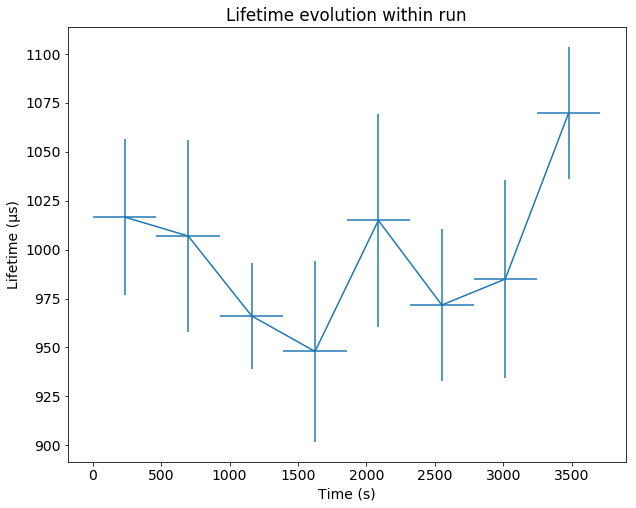

In [133]:
dst        = fid[coref.in_range(fid.Z, *zrange)]
timestamps = list(map(time_from_timestamp, dst.time))

lifetime_vs_t(dst, nslices=8, timestamps=timestamps)
plt.xlabel   ("Time (s)")
plt.ylabel   ("Lifetime (µs)")
plt.title    ("Lifetime evolution within run");

In [45]:
date_begin = time_from_timestamp(t_begin)
date_end   = time_from_timestamp(t_end  )
date_lapse = to_deltatime       (t_begin, t_end, unit="s", to_str=True)

save_lifetime(os.path.expandvars(text_filename),
               run_number,       LT,        LTu,
                  t_begin,    t_end,     run_dt,
               date_begin, date_end, date_lapse,
              comment = run_comment.replace(" ", "_"),
              delimiter=" ")